In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns
# from tqdm import

In [2]:
connectivity_min, connectivity_max = 10,65
# random_input_span = (1.2,2.8)
random_input_span = (9.5,13.5)
total_time = 100
alpha = 20
alpha_folder = 'alpha_' + str(alpha)

current_models = ['IF','Rotational']
neuron_model = current_models[1]

model_folder_name = neuron_model+'_ensembles'

# Capture related ensembles

In [3]:
def list_folders_in_path(path):
    return [ name for name in os.listdir( path ) if os.path.isdir( os.path.join(path, name) ) ]

In [4]:
num_neurons = 10000
target_networks_name = 'N{}_T{}_I{}_{}'.format(num_neurons,total_time,random_input_span[0],random_input_span[1])
target_path = os.path.join(model_folder_name,target_networks_name)
all_g_folders = list_folders_in_path(target_path)
desired_g_folders = all_g_folders

# delay_folder_name = 'd_{}'.format(delay)

In [5]:
sigma_glossary_dict = {}
amin_saman_param_glossary_dict = {}
field_period_glossary_dict = {}
field_max_intensity_mod_glossary_dict = {}

In [6]:
for g_folder in desired_g_folders:
    available_d_folders = list_folders_in_path(os.path.join(target_path,g_folder))

    g = float( g_folder.split('_')[1] ) #folder names are g_# d_#
    
    sigma_glossary_dict[g] = {}
    amin_saman_param_glossary_dict[g] = {}
    field_period_glossary_dict[g] = {}
    field_max_intensity_mod_glossary_dict[g] = {}
    
    for d_folder in available_d_folders:
        delay = float( d_folder.split('_')[1] ) #folder names are d_#
        
        g_d_alpha_path = os.path.join(target_path, g_folder, d_folder, alpha_folder)

        try:
            g_ensembles_list = list_folders_in_path(g_d_alpha_path)
            
            sigma_glossary_dict[g].update( {delay:[]} )
            amin_saman_param_glossary_dict[g].update( {delay:[]} )
            field_period_glossary_dict[g].update( {delay:[]} )
            field_max_intensity_mod_glossary_dict[g].update( {delay:[]} )
        except: #if the given connectivity and delay has not been measured even once
            continue

        for ensemble_num in g_ensembles_list:
            ensemble_path = os.path.join(g_d_alpha_path, ensemble_num)
            with open( os.path.join(ensemble_path,'sigma.txt') ) as file:
                sigma = float( file.readline() )
                sigma_glossary_dict[g][delay].append( sigma )

            with open( os.path.join(ensemble_path,'field_properties.txt') ) as file:
                info_line = file.readline()
                field_period = float( info_line.split(',')[0] )
                max_intensity_mod = float( info_line.split(',')[1] )
                field_period_glossary_dict[g][delay].append( field_period )
                field_max_intensity_mod_glossary_dict[g][delay].append( max_intensity_mod )

            if neuron_model == 'Rotational': #if not does not exist
                with open( os.path.join(ensemble_path,'amin_saman_param.txt') ) as file:
                    amin_saman_param = float( file.readline() )        
                    amin_saman_param_glossary_dict[g][delay].append( amin_saman_param )        


        sigma_glossary_dict[g][delay] = np.mean(sigma_glossary_dict[g][delay])
        field_period_glossary_dict[g][delay] = np.mean(field_period_glossary_dict[g][delay])
        field_max_intensity_mod_glossary_dict[g][delay] = np.mean(field_max_intensity_mod_glossary_dict[g][delay])
        if neuron_model == 'Rotational':amin_saman_param_glossary_dict[g][delay] = np.mean(amin_saman_param_glossary_dict[g][delay])


In [7]:
def dict_to_dataframe(input_dict):
    table = pd.DataFrame.from_dict(input_dict)
    table.index.name = 'delay'
    table.columns.name = 'connectivity'
    table = table.sort_index(axis=1)
    return table

# Sigma dataframe

In [8]:
sigma_table = dict_to_dataframe(sigma_glossary_dict)
sigma_table

connectivity,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0
delay,,,,,,,,,,
0.05,0.167872,0.167720,0.167078,0.167023,0.167579,0.167865,0.167780,0.170227,0.169699,0.170796
0.07,0.196380,0.195429,0.197957,0.199235,0.200538,0.201604,0.208656,0.247640,0.280912,0.291431
0.09,0.207596,0.210160,0.213143,0.217243,0.228900,0.324822,0.349704,0.360097,0.363623,0.366055
0.11,0.211495,0.213414,0.217222,0.321470,0.384393,0.401465,0.411640,0.412364,0.413068,0.412040
0.13,0.218880,0.222753,0.338724,0.424432,0.440598,0.448139,0.450721,0.451827,0.449247,0.447750
0.15,0.239931,0.262080,0.447000,0.472626,0.481298,0.500514,0.507365,0.501756,0.493666,0.486561
0.17,0.226356,0.402045,0.475271,0.491653,0.500604,0.505129,0.506932,0.507237,0.508038,0.507366
0.19,0.231787,0.476604,0.516902,0.527819,0.531693,0.531041,0.531129,0.532071,0.536630,0.542897
0.21,0.258470,0.512149,0.539000,0.546724,0.551726,0.552869,0.555600,0.560189,0.570606,0.575562


Text(0.5, 1, 'Sigma as an Order parameter')

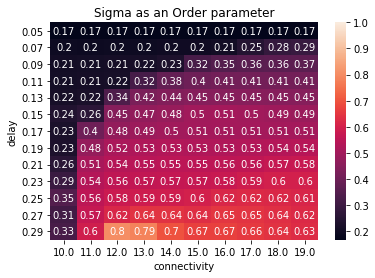

In [9]:
ax_sigma = sns.heatmap(sigma_table, annot=True, vmax = 1)
ax_sigma.set_title('Sigma as an Order parameter')

# Field period dataframe

In [10]:
field_period_table = dict_to_dataframe(field_period_glossary_dict)
field_period_table

connectivity,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0
delay,,,,,,,,,,
0.05,0.980392,1.031037,0.000000,0.000000,1.142894,0.000000,1.227410,-1.234568,1.114719,1.014160
0.07,0.980392,-1.020408,0.005720,0.000000,0.004354,0.298774,0.298507,0.307226,0.000000,0.320513
0.09,0.000000,0.679696,0.350877,0.364300,0.353361,0.361011,0.371747,0.381679,0.389865,0.399203
0.11,0.000000,0.435748,0.392965,0.400803,0.000000,0.000000,0.439563,0.000000,0.461896,0.471698
0.13,0.446437,0.455602,0.442478,0.460829,0.000000,0.490196,0.505051,0.518135,0.000000,-0.001485
0.15,0.001196,0.484287,-0.501256,0.000000,0.537634,0.000000,0.579715,0.595238,0.001848,0.623059
0.17,0.246294,0.533337,0.554021,0.574713,0.595238,0.617284,0.636943,0.657895,0.000000,0.704225
0.19,0.561815,0.000000,0.000000,0.632911,-0.002150,0.000000,0.704225,0.729927,0.763359,-0.006400
0.21,0.607908,0.002016,0.662252,0.689655,0.716855,0.746269,0.781250,0.813008,0.858385,0.000000


Text(0.5, 1, 'Field period time')

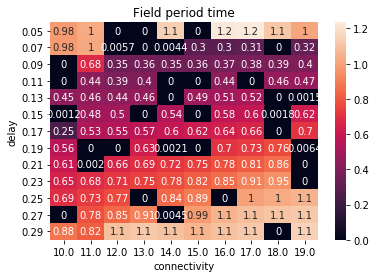

In [11]:
ax_field_period = sns.heatmap(field_period_table.abs(), annot=True)
ax_field_period.set_title('Field period time')

In [12]:
max_intensity_table = dict_to_dataframe(field_max_intensity_mod_glossary_dict)
max_intensity_table

connectivity,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0
delay,,,,,,,,,,
0.05,111.098218,100.711163,105.725556,106.723980,105.588995,110.008101,90.024753,96.895734,86.520668,89.113702
0.07,145.427531,141.835085,127.174556,131.659071,118.428206,125.570274,242.924273,636.876227,1089.600697,1011.783437
0.09,141.178978,143.584141,209.626425,200.952646,357.535194,1330.035673,1535.164088,1840.075700,1620.626767,1619.746216
0.11,163.128596,138.658692,176.623263,1443.500217,1817.790653,2225.079753,1885.643864,2194.577681,2144.175341,2301.972769
0.13,174.080622,207.972613,1332.035509,2157.986397,2491.189575,2240.806121,2538.297497,2485.147783,2220.008637,1962.742695
0.15,431.846106,419.279039,2110.968010,1956.767556,2175.245532,2425.191006,2495.604374,2449.472618,2341.929560,2222.274161
0.17,233.838212,1574.571781,2000.413907,2495.003991,2416.609717,2335.962961,2437.350097,2892.521341,2560.020716,2795.435319
0.19,264.094604,2789.347740,2987.741652,3123.419387,2598.522212,2710.618265,3066.060654,2753.886977,2982.104707,2344.263360
0.21,571.813332,2671.743365,3148.510273,2860.524600,2558.422143,2643.191409,2467.054552,2962.561581,2858.614293,2644.679991


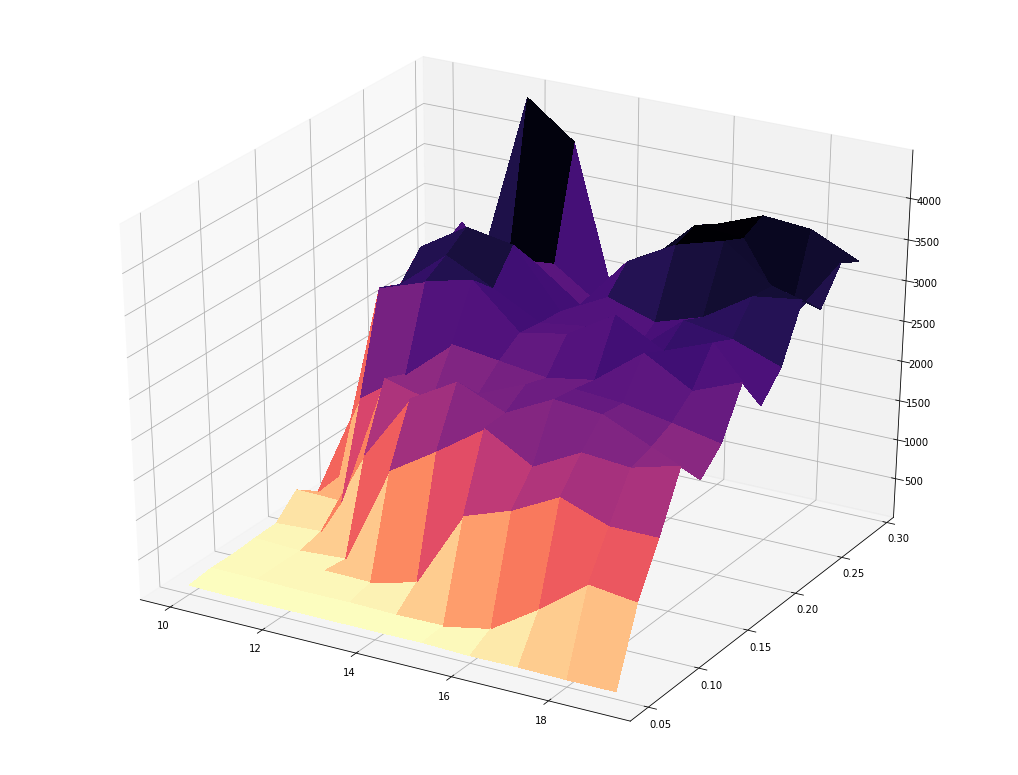

In [33]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import LinearLocator, FormatStrFormatter
y = list(max_intensity_table.index)
x = list(max_intensity_table.columns)
xx, yy = np.meshgrid(x, y)

fig = plt.figure(figsize=(18, 14))
ax = fig.gca(projection='3d')
surf = ax.plot_surface(xx, yy, max_intensity_table.to_numpy(), rstride=1, cstride=1, cmap='magma_r',
                       linewidth=0, antialiased=False)

111.09821761669029

# Amin Saman Parameter

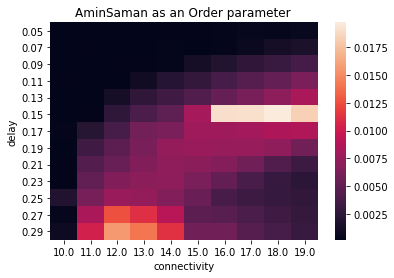

In [13]:
if neuron_model == 'Rotational':
    amin_saman_param_table = dict_to_dataframe(amin_saman_param_glossary_dict)
    ax_field_period = sns.heatmap(amin_saman_param_table)
    ax_field_period.set_title('AminSaman as an Order parameter ')